In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = "black"
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

MC Run

In [3]:
from joblib import Parallel, delayed
from tqdm import tqdm

from data_simulation.simulate_data import Experiment
from cluster_initialization.init_class import Cluster_initialization

from em_algorithm.processing_results import process_parallel_results
from em_algorithm.em_funcs import run_EM
from model_selection.scoreboard import create_scoreboard


from mc_simulation.preparation import initialize_results_dict

pd.options.mode.chained_assignment = None 

N_data = 2 # number of experiments
max_cluster_number = 4 # max number of clusters in experiment
em_params = {
    "max_iter": 500,
    "em_tol": 1e-4,
    "min_mix_coef": 0.00
}

cluster_init_params = {
    "N_cluster_max": 10,
    "N_runs_per_clusternumber": 12
}

init_routines = ["OPTICS", "random_inside"]
run_results = initialize_results_dict(init_routines=init_routines)

run_data = {}
for n_data in tqdm(range(N_data)):
    exp = Experiment(max_cluster_number=max_cluster_number)
    df, X = exp.df, exp.X
    run_data[n_data] = exp
    for init in tqdm(init_routines):
        cluster_init = Cluster_initialization(df, routine = init)
        params_array = cluster_init.init_params_array
        init_params = cluster_init.init_params
        cluster_init.sample(**cluster_init_params)
        init_params_arrays = cluster_init.sampled_init_params_array
        parallel_results = Parallel(n_jobs=10)(delayed(run_EM)(X, init_param_array, **em_params) for init_param_array in tqdm(init_params_arrays))
        
        results = process_parallel_results(parallel_results)
        df_scores, df_scores_na = create_scoreboard(results, X)
        print(f"Number of Singularites: {len(df_scores_na.index)}")

        run_results[init]["init_params"].append(cluster_init)
        run_results[init]["df_scores"].append(df_scores)
        run_results[init]["df_scores_na"].append(df_scores_na)


  0%|          | 0/2 [00:00<?, ?it/s]








100%|██████████| 91/91 [00:06<00:00, 14.34it/s]


Number of Singularites: 0







 50%|█████     | 1/2 [00:16<00:16, 16.02s/it]

Number of Singularites: 34



100%|██████████| 7/7 [00:00<00:00, 7022.27it/s]


Number of Singularites: 0









100%|██████████| 2/2 [00:39<00:00, 19.86s/it]

Number of Singularites: 8


In [4]:
from mc_simulation.after_processing import process_run_results

df_total = process_run_results(run_results, run_data)

In [5]:
import seaborn as sns
from plotting.mc_simulation.criteria_performance import add_score_performance_plot
from plotting.mc_simulation.init_performance import add_init_rout_performance_plot

settings = {
    "ax_title_size": 18,
    "axis_label_size": 20
}

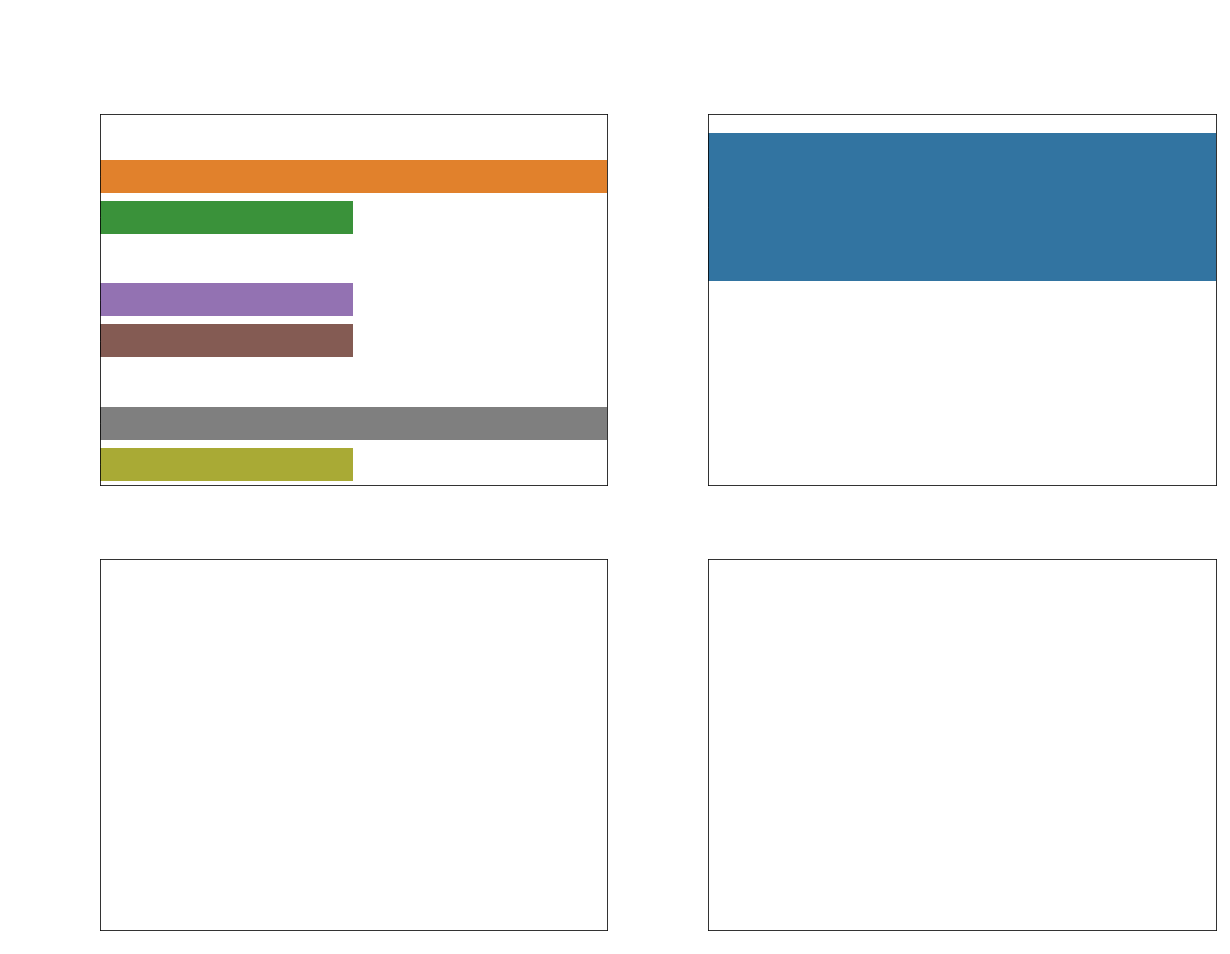

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 15)
fig.suptitle("Prediction of Number of Clusters", color="white", size=30)

add_score_performance_plot(df_total, axs[0,0], settings)
total_rank = "Total_prop_rank"
add_init_rout_performance_plot(df_total,axs[0,1], settings, total_rank=total_rank)